In [1]:
import preprocessing.read as r
import preprocessing.st_ops as ops
import preprocessing.feature_ops as feat
import visualization.builders as vis

import torch

from torch_geometric.data import Data
from torch_geometric.data import Batch

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
from IPython.display import display

import numpy as np
from scipy.spatial.transform import Rotation as R

from pythreejs import *

from math import pi

from sklearn.model_selection import KFold

In [2]:
def animate_function(i, action, edges, node_html_colors):
    colors = [[1,0,0],[0,0.5,0],[0,0.8,0.8],[0.8,0.8,0],[0,0,1]]
    ax.clear()
    ax.axis([-1.5, 1.5, -1.5 ,1.5])
    frame = action[i]
    axis_x = frame[:,0]
    axis_y = frame[:,1]
    for edge_index in range(edges.shape[1]):        
        s_x = axis_x[edges[0,edge_index]]
        s_y = axis_y[edges[0,edge_index]]
        t_x = axis_x[edges[1,edge_index]]
        t_y = axis_y[edges[1,edge_index]]
        line = plt.Line2D((s_x,t_x), (s_y,t_y))
        ax.add_artist(line)
    for node_index in range(len(axis_x)):
        node_color = matplotlib.colors.to_rgb(node_html_colors[node_index])
        circle = plt.Circle((axis_x[node_index], axis_y[node_index]), .05, color=node_color)
        ax.add_artist(circle)
        ax.annotate(node_index, xy=(axis_x[node_index], axis_y[node_index]))

In [3]:
def normalize_data(athletes):
    for athlete in athletes:

        min_y = float("inf")
        max_y = -float("inf")
        min_x = float("inf")
        max_x = -float("inf")
        min_z = float("inf")
        max_z = -float("inf")

        for _, activity in athlete.activities.items():
            for sample in activity:
                min_x = min(min_x, sample[:,:,0].min())
                max_x = max(max_x, sample[:,:,0].max())
                min_y = min(min_y, sample[:,:,1].min())
                max_y = max(max_y, sample[:,:,1].max())
                min_z = min(min_z, sample[:,:,2].min())
                max_z = max(max_z, sample[:,:,2].max())
            
        scale = (max_y - min_y)/2  # A mesma escala será usada nas 3 dimensões para preservar proporção
        move_x = -(min_x + max_x)/2
        move_y = -(min_y + max_y)/2
        move_z = -(min_z + max_z)/2

        for _, activity in athlete.activities.items():
            for sample in activity:
                sample[:,:,0] = (sample[:,:,0] + move_x)/scale
                sample[:,:,1] = (sample[:,:,1] + move_y)/scale
                sample[:,:,2] = (sample[:,:,2] + move_z)/scale

In [21]:
def data_augmentation(athletes, rotate=True, noise=True):  
    n_athletes = len(athletes)
    
    angle = np.random.randint(50) - 25 ## ANGLE FIXED FOR ALL ATHLETES
    for base_idx in range(n_athletes):
        base_athlete = athletes[base_idx]
    
        for label, base_activity in base_athlete.activities.items():
            base_sample = base_activity[0] ## Original sample
            if rotate:
                base_sample = feat.rotate(base_sample, angle)
            if noise:
                base_sample = feat.apply_noise(base_sample, 0.1)
            athletes[base_idx].add(label, base_sample)

In [5]:
from IPython.display import clear_output, display

def create_activity_sequence(athlete, act_idx):
    sequence_frames = []
    sequence_labels = []

    # Build graph
    for label, _ in athlete.activities.items():
        frames = athlete.get(label, act_idx)
        sequence_frames.append(frames)

    sequence_frames = np.concatenate( sequence_frames )
    sequence_st_data, sequence_st_edges = ops.create_st_graph(unfold_features(sequence_frames), edges, 16)



    # Build labels
    for label, _ in athlete.activities.items():
        frames = athlete.get(label, act_idx)
        total_nodes = frames.shape[0]*frames.shape[1]
        sequence_labels.append(np.ones(total_nodes) * label_idx[label])

    sequence_labels = np.concatenate( sequence_labels )
    # sequence_labels = indices_to_one_hot(sequence_labels, 7)
    
    data = Data(
                x=torch.tensor(sequence_st_data, dtype=torch.float), 
                edge_index=torch.tensor(sequence_st_edges, dtype=torch.long), 
                y=torch.tensor(sequence_labels, dtype=torch.long)
                )
    
    return data

def create_batch(train_athletes, val_athletes):
    n_samples = len(train_athletes[0].activities['Back Kick'])
    
    train_list = []
    validation_list = []
    
    for act_idx in range(n_samples):
        
        train_seq = [create_activity_sequence(train_athlete, act_idx) for train_athlete in train_athletes]
        validation_seq = [create_activity_sequence(val_athlete, act_idx) for val_athlete in val_athletes]
        
        train_list.extend(train_seq)
        validation_list.extend(validation_seq)

    train_batch = Batch.from_data_list(train_list)
    validation_batch = Batch.from_data_list(validation_list)

    return train_batch, validation_batch

In [6]:
def unfold_features(data):
    num_samples = data.shape[0]
    num_frames = data.shape[1]
    num_nodes = data.shape[2]
    num_dim = data.shape[3]
    res = np.zeros((num_samples, num_frames, num_nodes, num_nodes*num_dim))
    for sample_idx in range(num_samples):
        for frame_idx in range(num_frames):
            for node_idx in range(num_nodes):
                res[sample_idx, frame_idx, node_idx, num_dim*node_idx:num_dim*(node_idx+1)] = data[sample_idx, frame_idx, node_idx]
    return res

def indices_to_one_hot(data, num_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = data.reshape(-1).astype(int)
    return np.eye(num_classes)[targets]

In [22]:
loader = r.TaekwondoLoader('../dataset')
athletes, labels, label_idx = loader.load()

normalize_data(athletes)

In [23]:
n_aug = 60
for i in range(n_aug):
    data_augmentation(athletes)

In [9]:
adj_list = {
    0: [0, 3, 7, 15, 6],
    1: [1, 3, 8, 15, 6],
    2: [2, 15, 6],
    3: [3, 0, 1, 4, 5, 15, 6],
    4: [4, 3, 5, 12, 6],
    5: [5, 3, 4, 11, 6],
    6: [6, 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    7: [7, 0, 9, 6],
    8: [8, 1, 10, 6],
    9: [9, 7, 6],
    10: [10, 8, 6],
    11: [11, 5, 13, 6],
    12: [12, 4, 14, 6],
    13: [13, 11, 6],
    14: [14, 12, 6],
    15: [15, 0, 1, 2, 3, 6]
}
def order(s, t):
    if s > t:
        return (t, s)
    else:
        return (s, t)
    
edges = set()
num_node = 16
for s in adj_list.keys():
    for t in adj_list[s]:
        edges.add(order(s, t))
        
def normalize_digraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    AD = np.dot(A, Dn)
    return AD

def get_hop_distance(num_node, edge, max_hop=1):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    # compute hop steps
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(max_hop, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

def get_adjacency(num_node, edges):

    valid_hop = range(0, 2, 1)
    adjacency = np.zeros((num_node, num_node))
    hop_dis = get_hop_distance(num_node, edges)
    for hop in valid_hop:
        adjacency[hop_dis == hop] = 1
    normalize_adjacency = normalize_digraph(adjacency)

    A = np.zeros((1, num_node, num_node))
    A[0] = normalize_adjacency
    return A



import pdb

In [10]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
from torch_scatter import scatter_mean

class ST_GCN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 1):
        super().__init__()
        self.kernel_size = kernel_size
        self.t_kernel_size = 3
        self.t_padding = 1
        self.conv = nn.Conv2d(in_channels,
                              out_channels * kernel_size,
                              kernel_size=(self.t_kernel_size, 1),
                              padding=(self.t_padding, 0),
                              stride=(1, 1),
                              dilation=(1, 1),
                              bias=True)
    
    def forward(self, x, A):
        assert A.size(0) == self.kernel_size

        x = self.conv(x)

        n, kc, t, v = x.size()
        x = x.view(n, self.kernel_size, kc // self.kernel_size, t, v)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))

        return x.contiguous(), A

In [11]:
def get_accuracy(out_tensor, labels_tensor):
    out_np = out_tensor.detach().cpu().numpy()
    out_np = np.array(np.argmax(out_np, axis=1))

    labels_np = np.array(labels_tensor.cpu().numpy())
    corrects = np.array(out_np == labels_np)

    result = np.sum(corrects) / (out_np.shape[0] * out_np.shape[1] * out_np.shape[2])
    return result

In [26]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.kernel_size = 1
        self.conv1 = ST_GCN(48, 8)
        self.conv2 = ST_GCN(8, 8)
        self.conv4 = ST_GCN(8, 7)
        
    def forward(self, x, A):
        x, A = self.conv1(x, A) 
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x, A = self.conv2(x, A)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x, A = self.conv4(x, A)
        x = F.relu(x)
        return F.softmax(x)

In [40]:
def train(train_batch, validation_batch, A, epochs=100, device=torch.device('cuda')):
    
    model = Net().to(device)
    samples, targets = train_batch
    val_samples, val_targets = validation_batch
    
    A = A.to(device, dtype=torch.float)
    
    train_data = torch.from_numpy(samples).to(device, dtype=torch.float)
    train_labels = torch.from_numpy(targets).to(device, dtype=torch.long)

    val_data = torch.from_numpy(val_samples).to(device, dtype=torch.float)
    val_labels = torch.from_numpy(val_targets).to(device, dtype=torch.long)
        
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.02, betas=(0.5, 0.999))
    model_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    model.train()
    
    loss_history_train = []
    acc_history_val = []
    acc_history_train = []
    epoch_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(train_data, A)
        loss = F.cross_entropy(out, train_labels)
        loss.backward()
        optimizer.step()
        total_loss = loss.item()
        if (epoch + 1) % 100 == 0:
            model.eval()
            
            train_acc = get_accuracy(out, train_labels)
            out_val = model(val_data, A)
            val_acc = get_accuracy(out_val, val_labels)
            loss_history_train.append(total_loss)
            acc_history_val.append(val_acc)
            acc_history_train.append(train_acc)
            epoch_history.append(epoch)
            clear_output(wait=True)

            print('[{}/{}] Loss: {:.4f} - Train Acc: {:.4f} - Val Acc: {:.4f}'.format(epoch, epochs, total_loss, train_acc, val_acc))
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
            ax1.plot(epoch_history, loss_history_train, 'b')
            ax1.grid()  
            ax2.plot(epoch_history, acc_history_train, 'b')
            ax2.plot(epoch_history, acc_history_val, 'r')
            ax2.grid()
            plt.show()

            model.train()
            
        '''if (epoch + 1) % 1000 == 0:
            filename = '../taekwondo_activity_segmentation_stgcn_epoch{}.pth'.format(epoch)
            torch.save(model, filename)'''
            
    return epoch_history, acc_history_val, acc_history_train, model

In [14]:
def prepare_data(athletes):
    samples = []
    targets = []
    
    labels = list(athletes[0].activities.keys())
    
    n_samples = len(athletes[0].activities['Back Kick'])
    label_idx = {key: idx for (idx, key) in enumerate(labels)}
    
    for sample in range(n_samples):
        for athlete in athletes:
            sequence_frames = []
            athlete_labels = []
            for label in labels:
                frames = athlete.get(label, sample)
                sequence_frames.append(frames)
                athlete_labels.append(np.ones(frames.shape)[:,:,0]*label_idx[label])

            sequence_frames = np.concatenate( sequence_frames )
            athlete_labels = np.concatenate( athlete_labels )
            samples.append(sequence_frames[:212])
            targets.append(athlete_labels[:212])
        
    samples = np.stack(samples)
    targets = np.stack(targets)

    return samples, targets

In [15]:
samples, labels = prepare_data(athletes)

In [18]:
device=torch.device('cuda')

In [19]:
adjacency = get_adjacency(num_node, edges)
A = torch.from_numpy(adjacency)

In [136]:
def get_accuracy2(out_tensor, labels_tensor):
    out_np = out_tensor.detach().cpu().numpy()
    out_np = np.array(np.argmax(out_np, axis=1))

    results = np.array([np.apply_along_axis(classify, 1, sample) for sample in out_np]) 
    results = results.flatten()
    
    labels_np = np.array(labels_tensor.cpu().numpy())
    results2 = np.array([np.apply_along_axis(classify, 1, sample) for sample in labels_np]) 
    results2 = results2.flatten()
    
    corrects = np.array(results == results2)

    result = np.sum(corrects) / (results.shape[0])
    return result

In [137]:
def classify(array):
    return np.bincount(array).argmax()  

In [147]:
def get_labels(preds):
    try:
        out_np = preds.detach().cpu().numpy()
        out_np = np.array(np.argmax(out_np, axis=1))
    except:
        out_np = preds
    
    results = np.array([np.apply_along_axis(classify, 1, sample) for sample in out_np]) 
    results = results.flatten()
    
    return results

[2999/3000] Loss: 1.3939 - Train Acc: 0.7850 - Val Acc: 0.7573


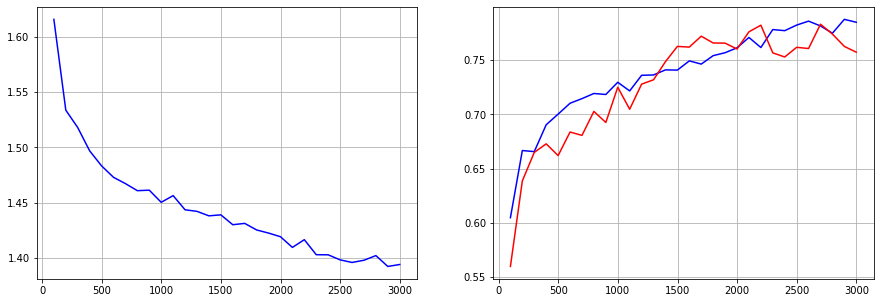

Exception: TESTE

In [158]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
kf.get_n_splits(athletes)

epochs = 3000

from tqdm import tqdm

folds_history = []
acc_val_hist = []
acc_train_hist = []
folds_labels = []
folds_preds = []

import pdb

for train_idxs, test_idxs in tqdm(kf.split(athletes), desc="Training model..."):
    
    train_athletes = [athletes[idx] for idx in train_idxs]
    test_athletes = [athletes[idx] for idx in test_idxs]
    
    train_data, train_labels = prepare_data(train_athletes)
    test_data, test_labels = prepare_data(test_athletes)
    
    train_data = unfold_features(train_data)
    test_data = unfold_features(test_data)
    
    train_data = train_data.transpose((0, 3, 1, 2))
    test_data = test_data.transpose((0, 3, 1, 2))
    
    fold_history, fold_acc_val, fold_acc_train, fold_model = train((train_data, train_labels), \
                                                                   (test_data, test_labels), \
                                                                   A, \
                                                                   epochs, device=torch.device('cuda'))
    
    fold_model.eval()
    test_data = torch.from_numpy(test_data).to(device, dtype=torch.float)
    A = A.to(device, dtype=torch.float)
    preds = fold_model(test_data, A)
    
    preds = get_labels(preds)
    test_labels = get_labels(test_labels.astype(int))
    
    folds_preds.append(preds)
    folds_labels.append(test_labels)
    folds_history.append(fold_history)
    acc_val_hist.append(fold_acc_val)
    acc_train_hist.append(fold_acc_train)
    
    del preds
    del fold_model
    del train_data
    del train_labels
    del test_data
    del test_labels
    del train_athletes
    del test_athletes
    torch.cuda.empty_cache()

In [159]:
def my_plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, fold_number=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import sklearn
    if not title:
        if normalize:
            title = 'Normalized confusion matrix - FOLD ' + str(fold_number)
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(16, 9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, animated=True, vmin = 0.0, vmax = 1.0)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    #plt.plot()
    return fig

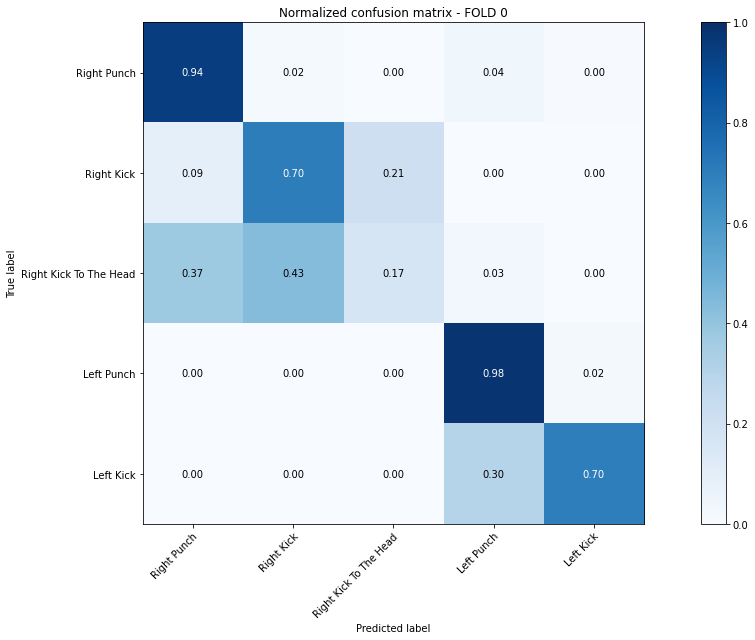

In [160]:
class_names = list(athletes[0].activities.keys())
import matplotlib.pyplot as plt
#range(len(folds_preds))
ims = []

import imageio
import sklearn
import matplotlib.animation as animation

for idx, fold in enumerate(range(len(folds_preds))):
    preds = folds_preds[fold]
    labels = folds_labels[fold]
    
    cm = my_plot_confusion_matrix(labels, preds, class_names, True, title='Normalized confusion matrix - FOLD ' + str(idx))
    ims.append(cm)

In [161]:
import os

for idx, fig in enumerate(ims):
    fig.savefig(str(idx) + '.png')
    
import imageio

images = []
for idx, image in enumerate(ims):
    images.append(imageio.imread(str(idx) + '.png'))
    
imageio.mimsave('confusion_matrix.gif', images, duration=3)

for idx, fig in enumerate(ims):
    os.system('rm ' + str(idx) + '.png')